# Waveletsdef ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma

In [73]:
import pandas as pd
from pathlib import Path
import pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set_theme()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [57]:
def reconstruction_plot(yyy, **kwargs):
    """Plot signal vector on x [0,1] independently of amount of values it contains."""
    ym = np.median(yyy)
    plt.plot(np.linspace(0, 1., num=len(yyy)), yyy-ym, **kwargs)


def reconstruction_stem(yyy, xmax, **kwargs):
    """Plot coefficient vector on x [0,1] independently of amount of values it contains."""
    ymax = yyy.max()
    plt.stem(np.linspace(0, 1., num=len(yyy)), yyy*(xmax/ymax), **kwargs)


In [2]:
fpath = Path("/home/mst/projects/flyps/myalyce/data/Unfiltered PPG, plus accelerometer/PPG_JoshuaBrewster2023-06-14T15_48_32.828(UTC-07_00).csv")

In [3]:
df = pd.read_csv(fpath)

In [4]:
df

,timestamp,localized,red,ir
0,1686782913042,2023-06-14T15:48:33.042(UTC-07:00),26462,44429
1,1686782913041,2023-06-14T15:48:33.041(UTC-07:00),26465,44426
2,1686782913040,2023-06-14T15:48:33.040(UTC-07:00),26458,44411
3,1686782913039,2023-06-14T15:48:33.039(UTC-07:00),26457,44406
4,1686782913037,2023-06-14T15:48:33.037(UTC-07:00),26457,44407
...,...,...,...,...
2555,1686782963623,2023-06-14T15:49:23.623(UTC-07:00),26601,44406
2556,1686782963643,2023-06-14T15:49:23.643(UTC-07:00),26601,44401
2557,1686782963663,2023-06-14T15:49:23.663(UTC-07:00),26601,44391
2558,1686782963683,2023-06-14T15:49:23.683(UTC-07:00),26587,44348


In [5]:
melted = pd.melt(df, id_vars=['timestamp'], value_vars=['red','ir'])

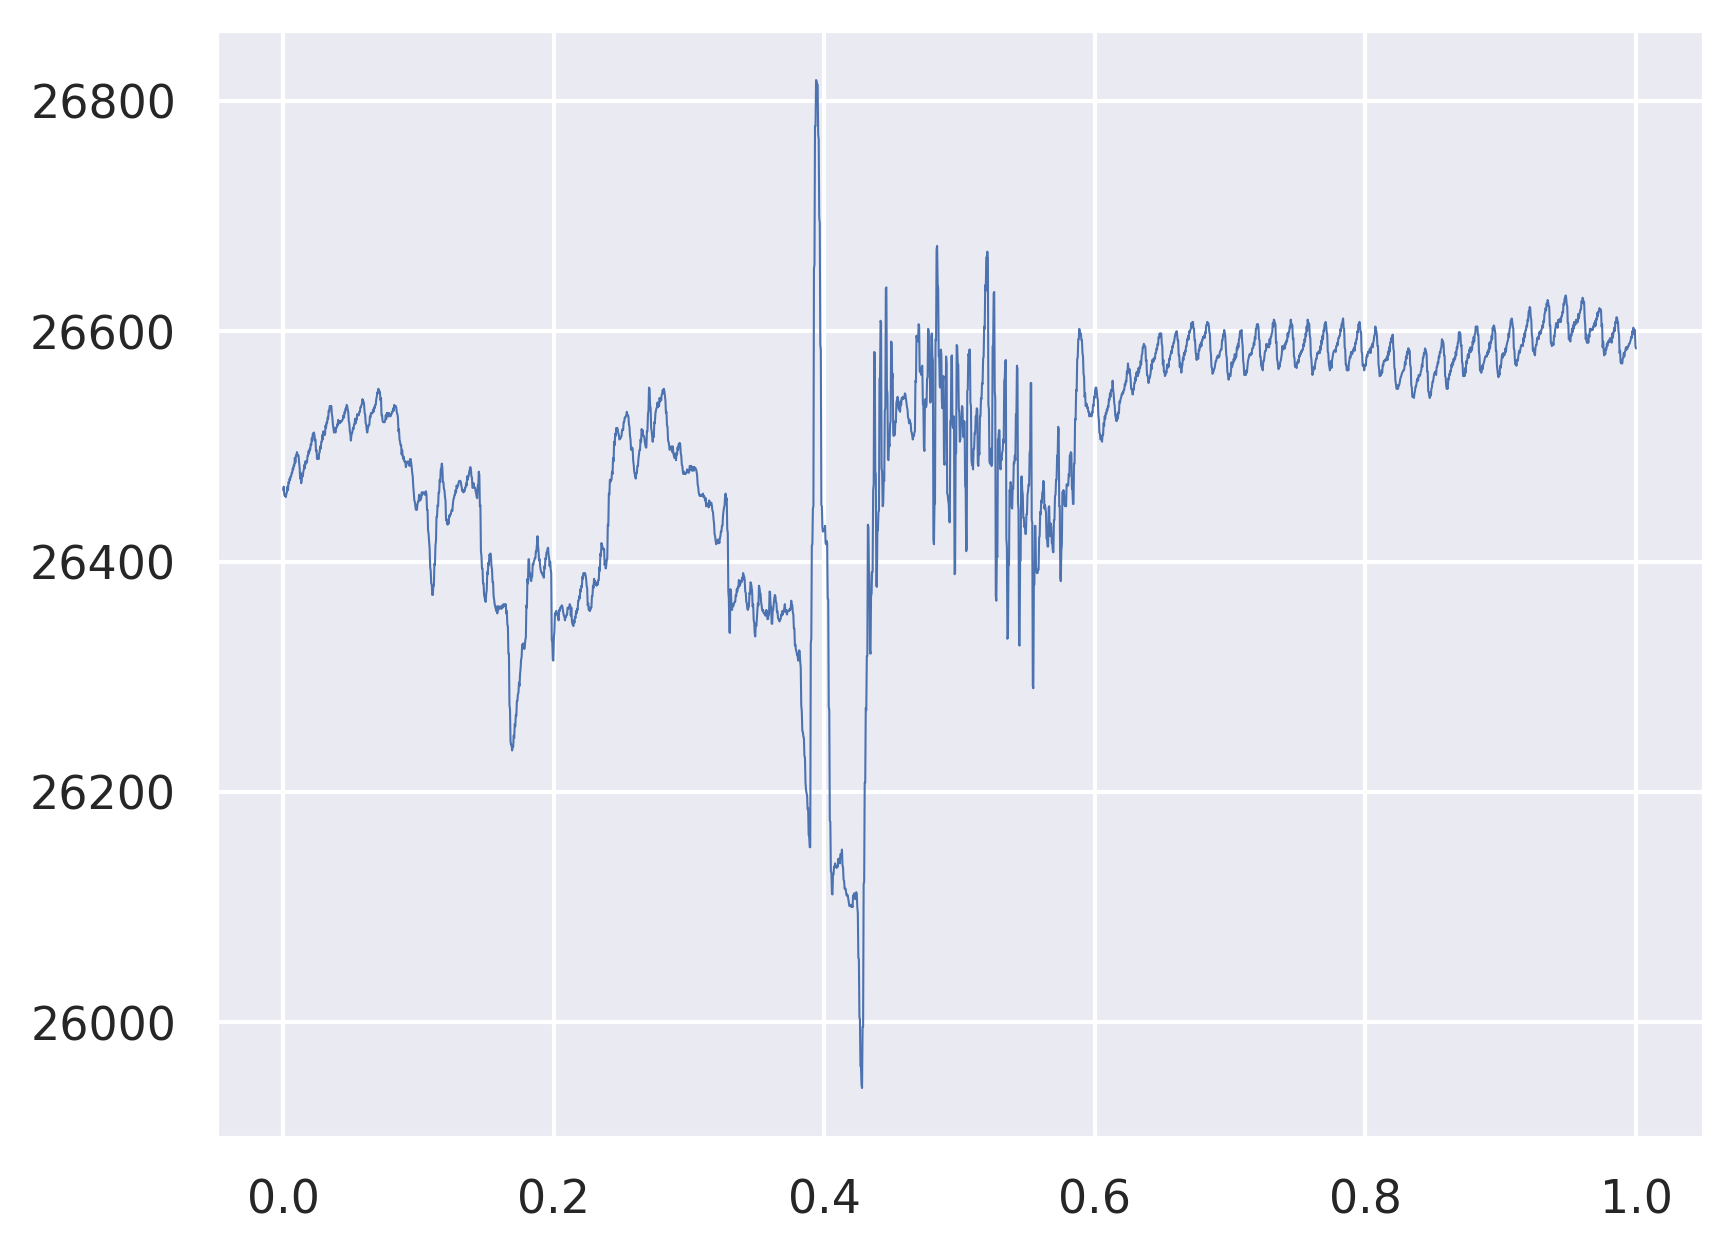

In [77]:
plt.plot(np.linspace(0, 1., num=len(df['red'])), df['red'], lw=0.5)

In [33]:
y_denoise = denoise_wavelet(df['red'], method='VisuShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
x_denoise = np.linspace(0,1,len(y_denoise))

In [34]:
data = df['red']
w = pywt.Wavelet('sym4')
maxlev = pywt.dwt_max_level(len(data), w.dec_len)
threshold = 0.04
coeffs = pywt.wavedec(data, 'sym4', level=maxlev)


In [10]:
for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

datarec = pywt.waverec(coeffs, 'sym4')

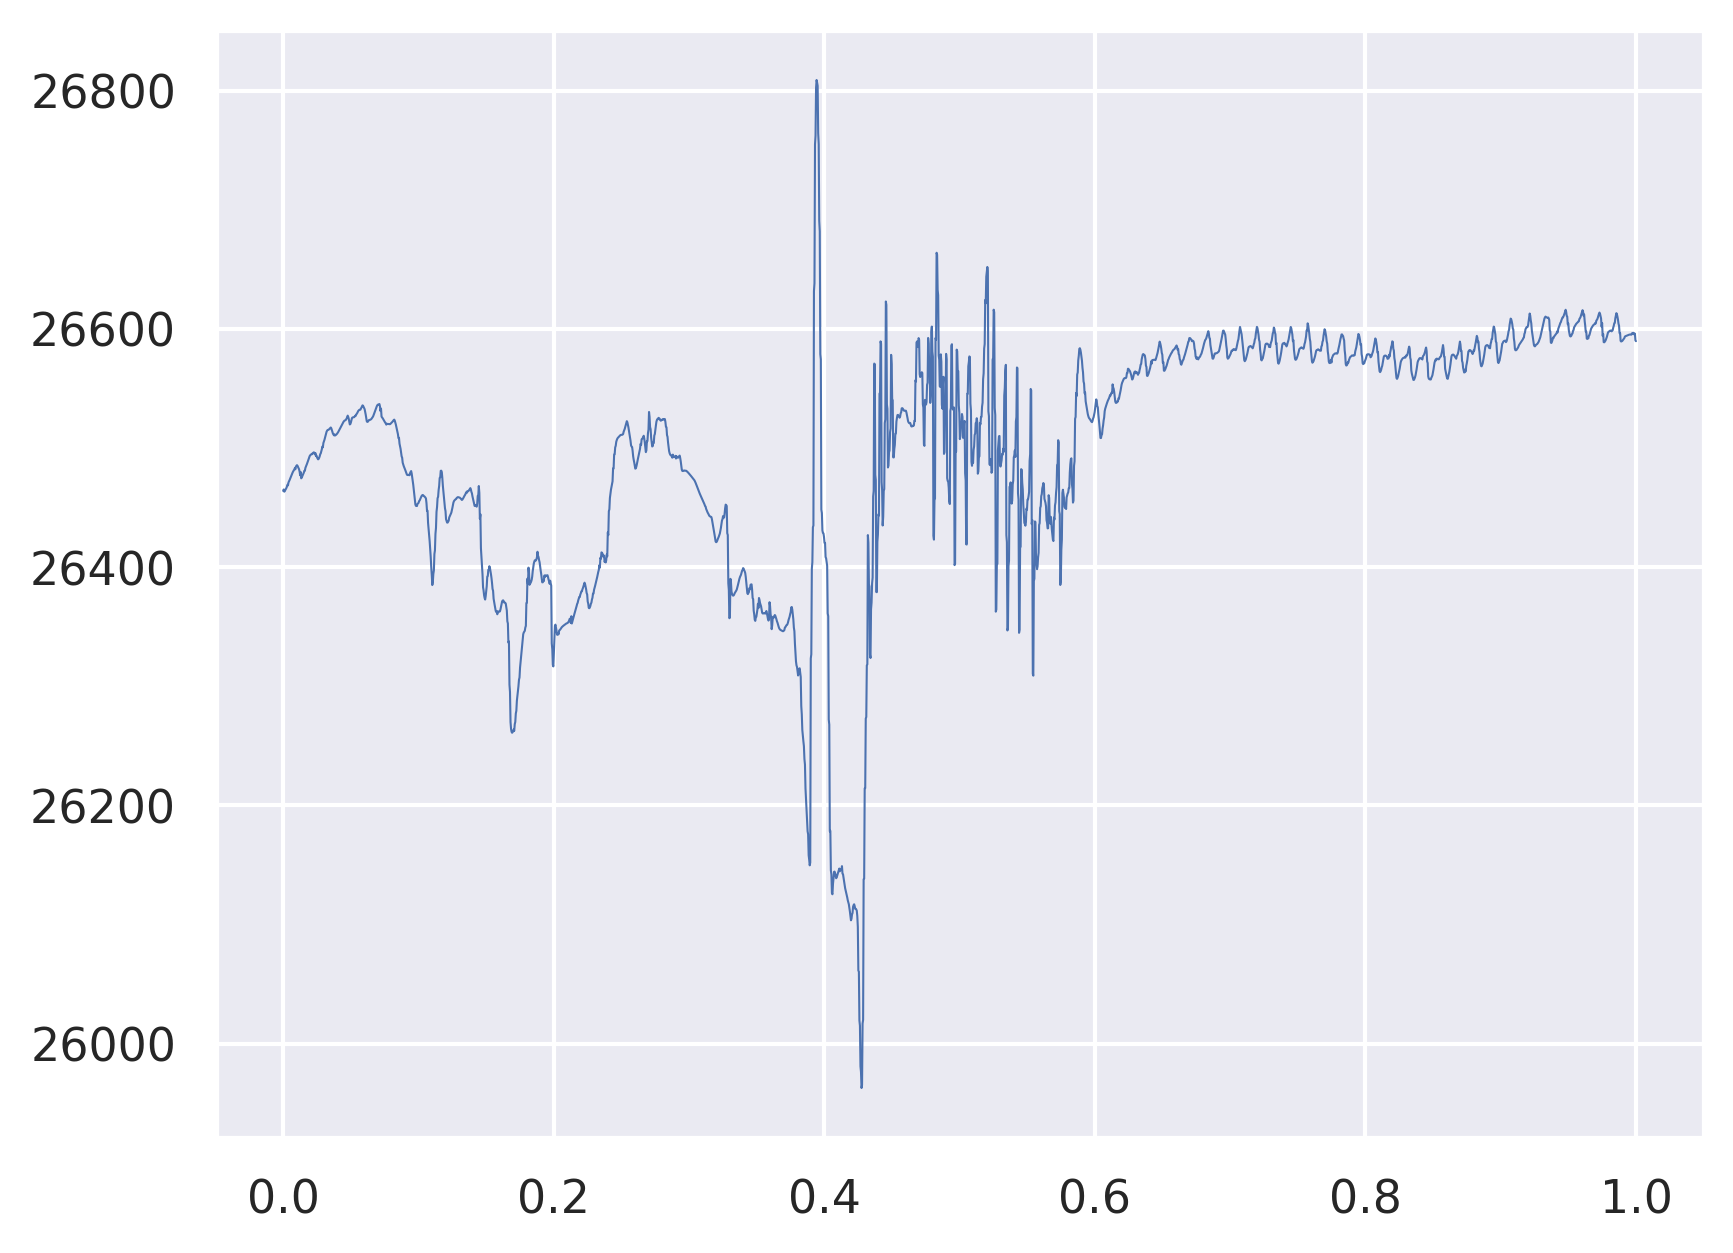

In [78]:
plt.plot(np.linspace(0, 1., num=len(datarec)), datarec, lw=0.5)

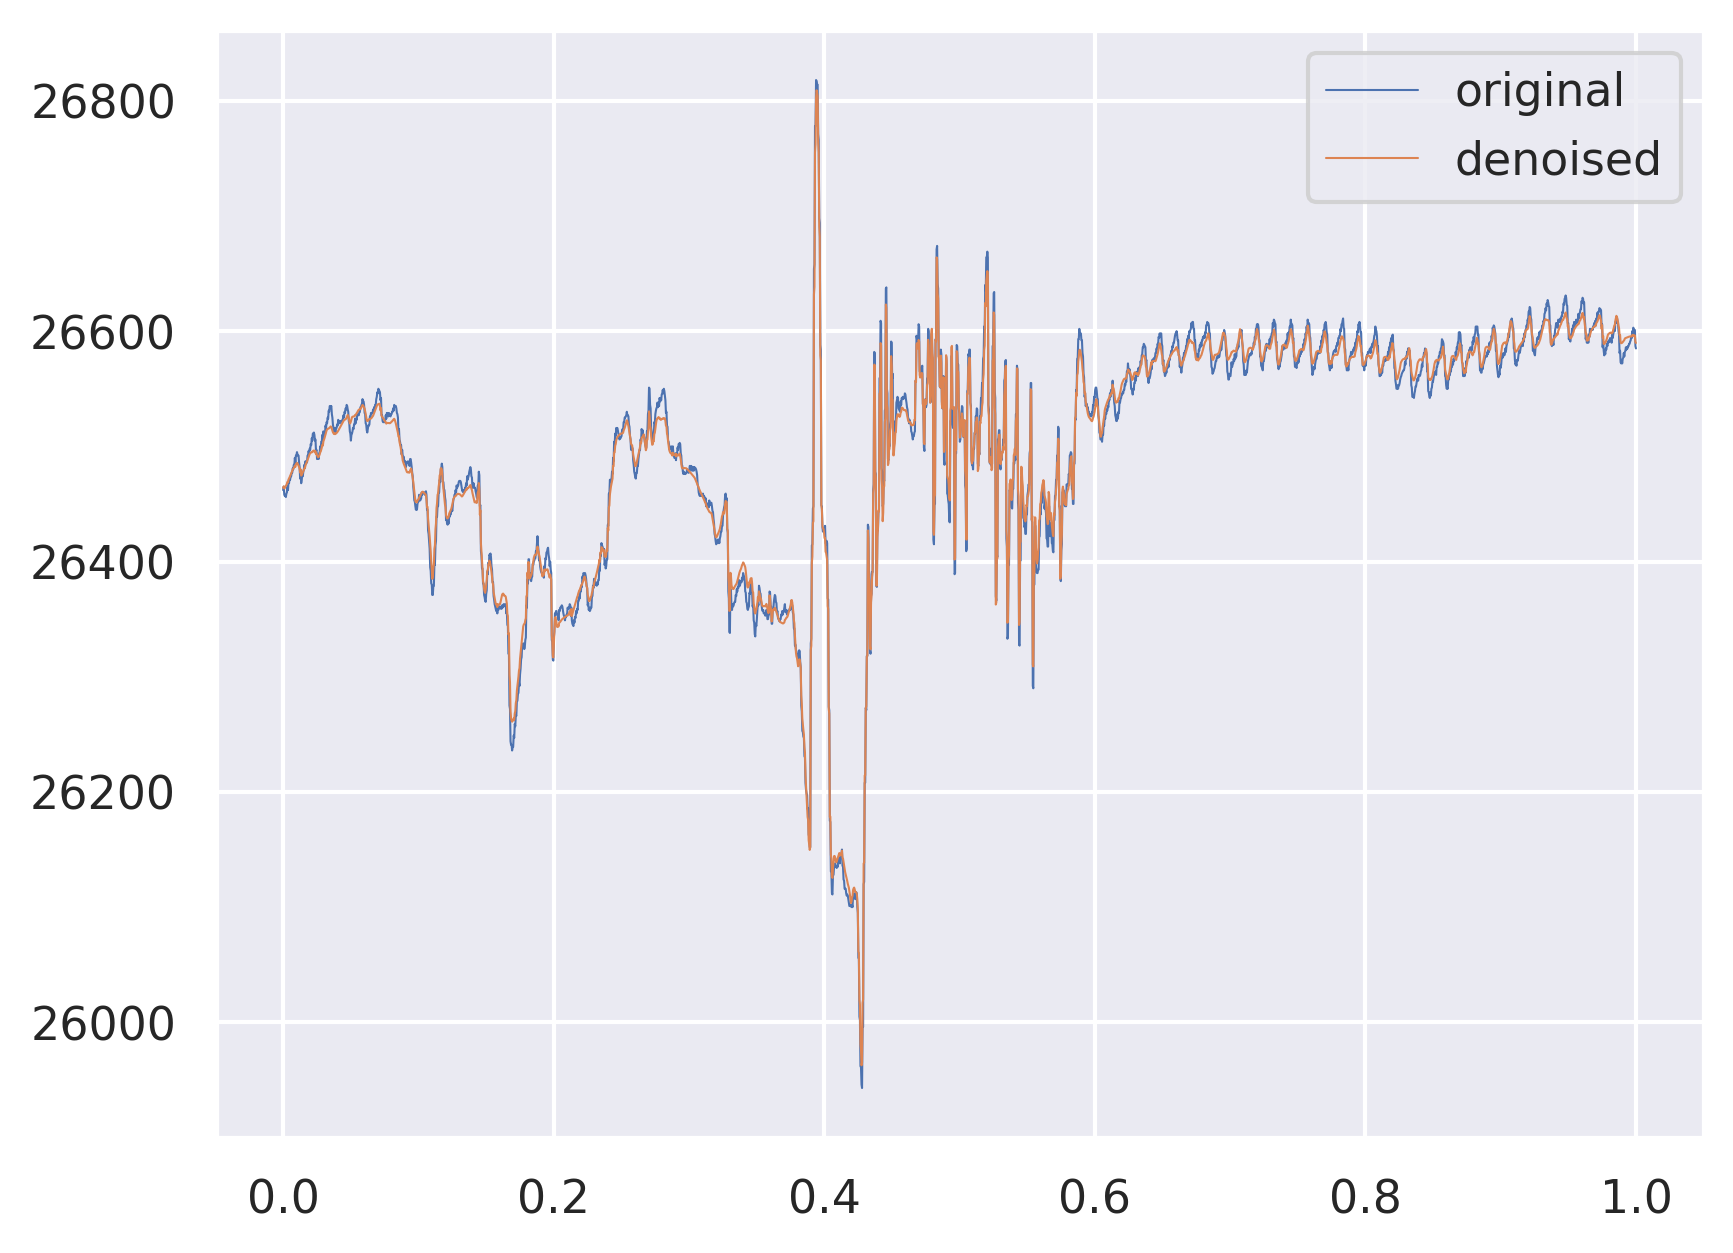

In [82]:
plt.figure()
plt.plot(np.linspace(0, 1., num=len(df['red'])), df['red'], lw=0.5)
plt.plot(np.linspace(0, 1., num=len(datarec)), datarec, lw=0.5)
plt.legend(['original', 'denoised'])

9

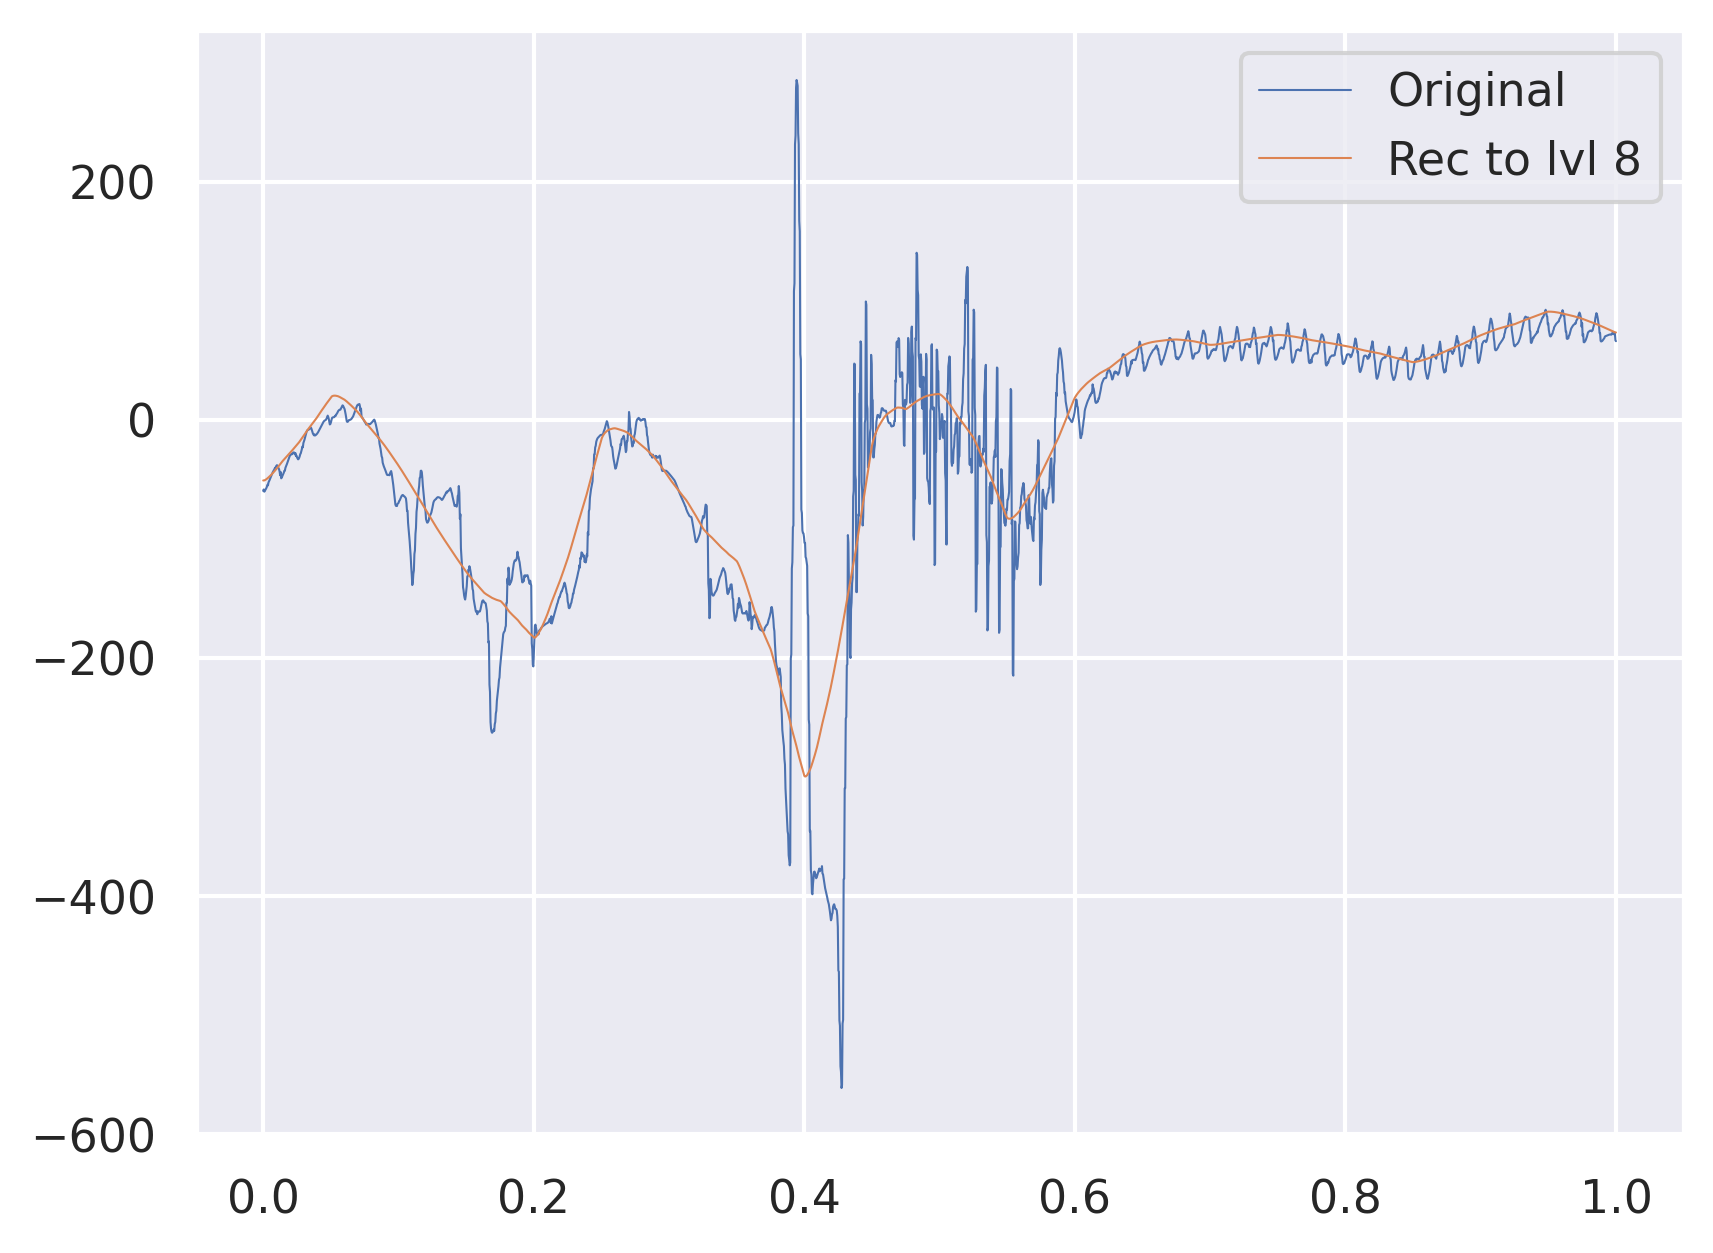

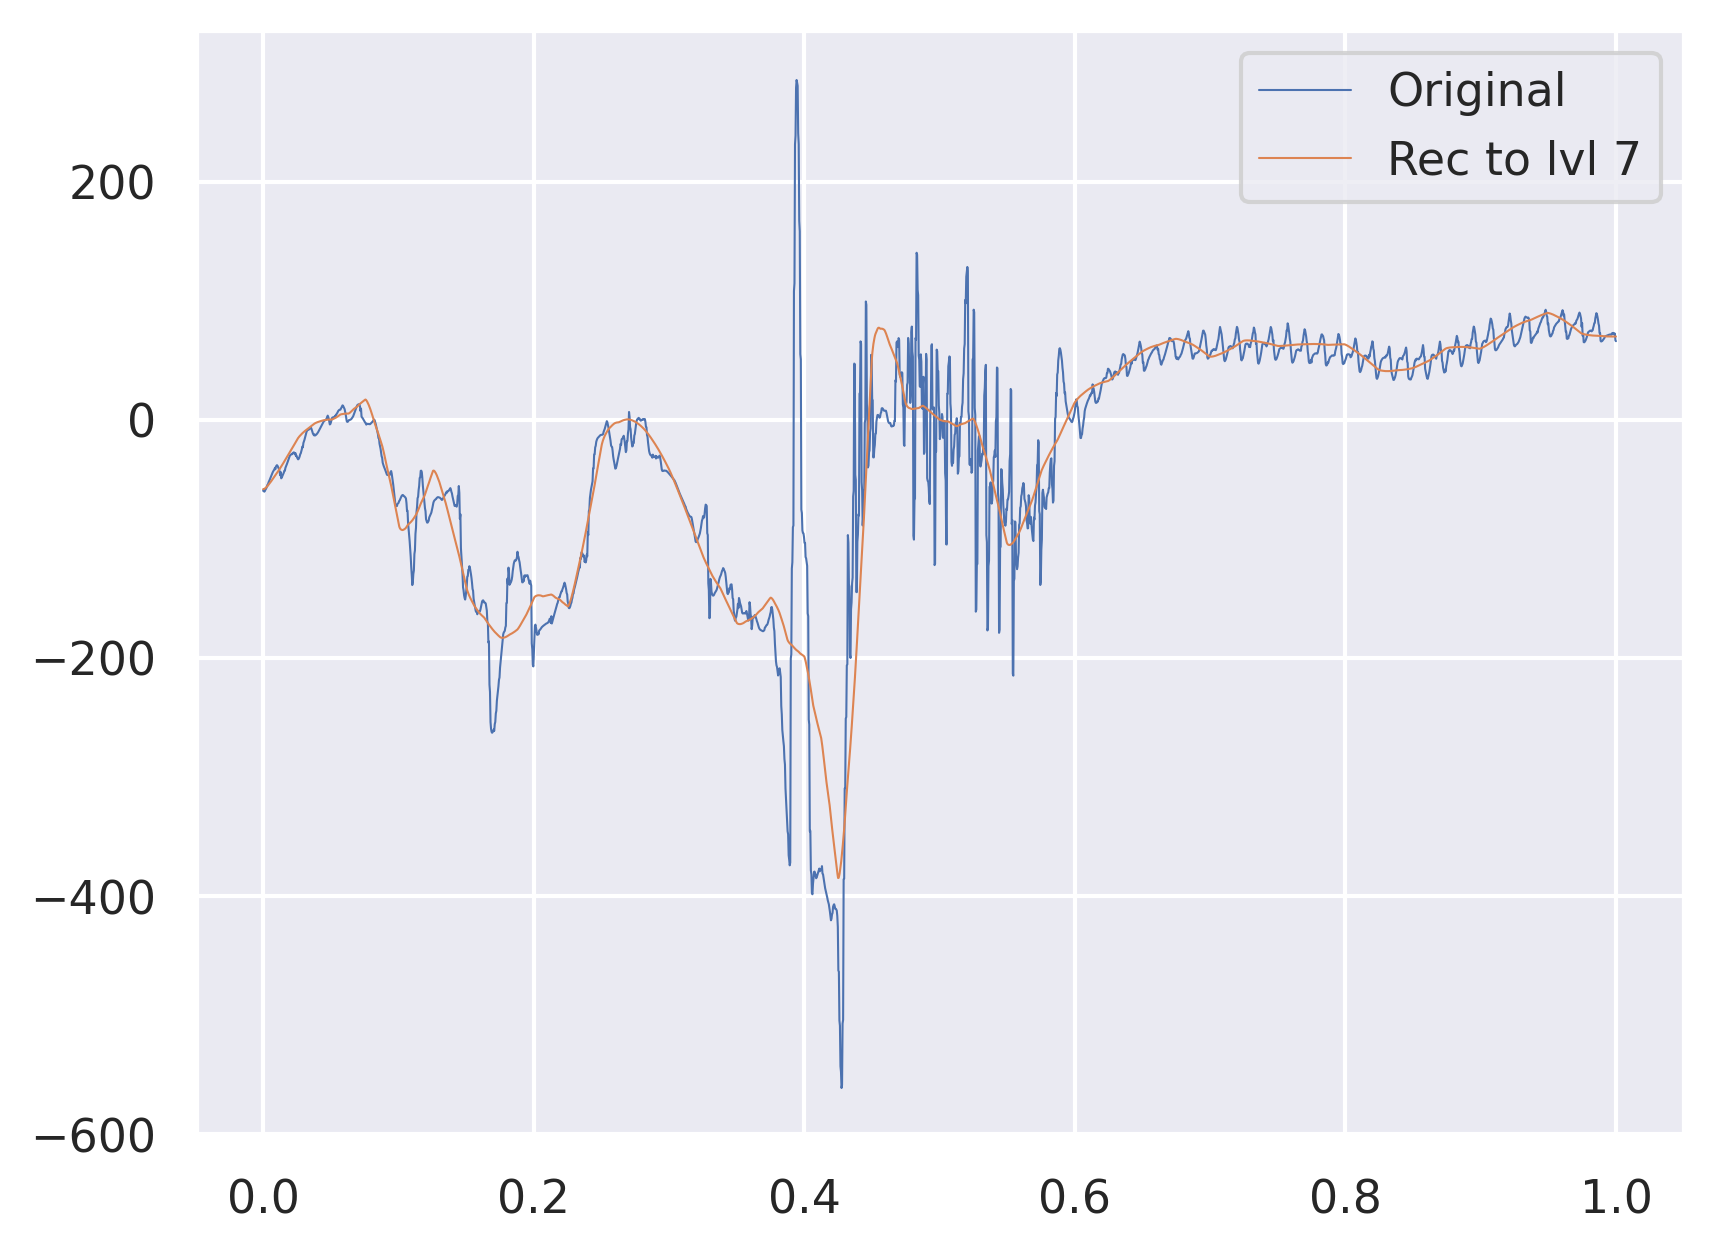

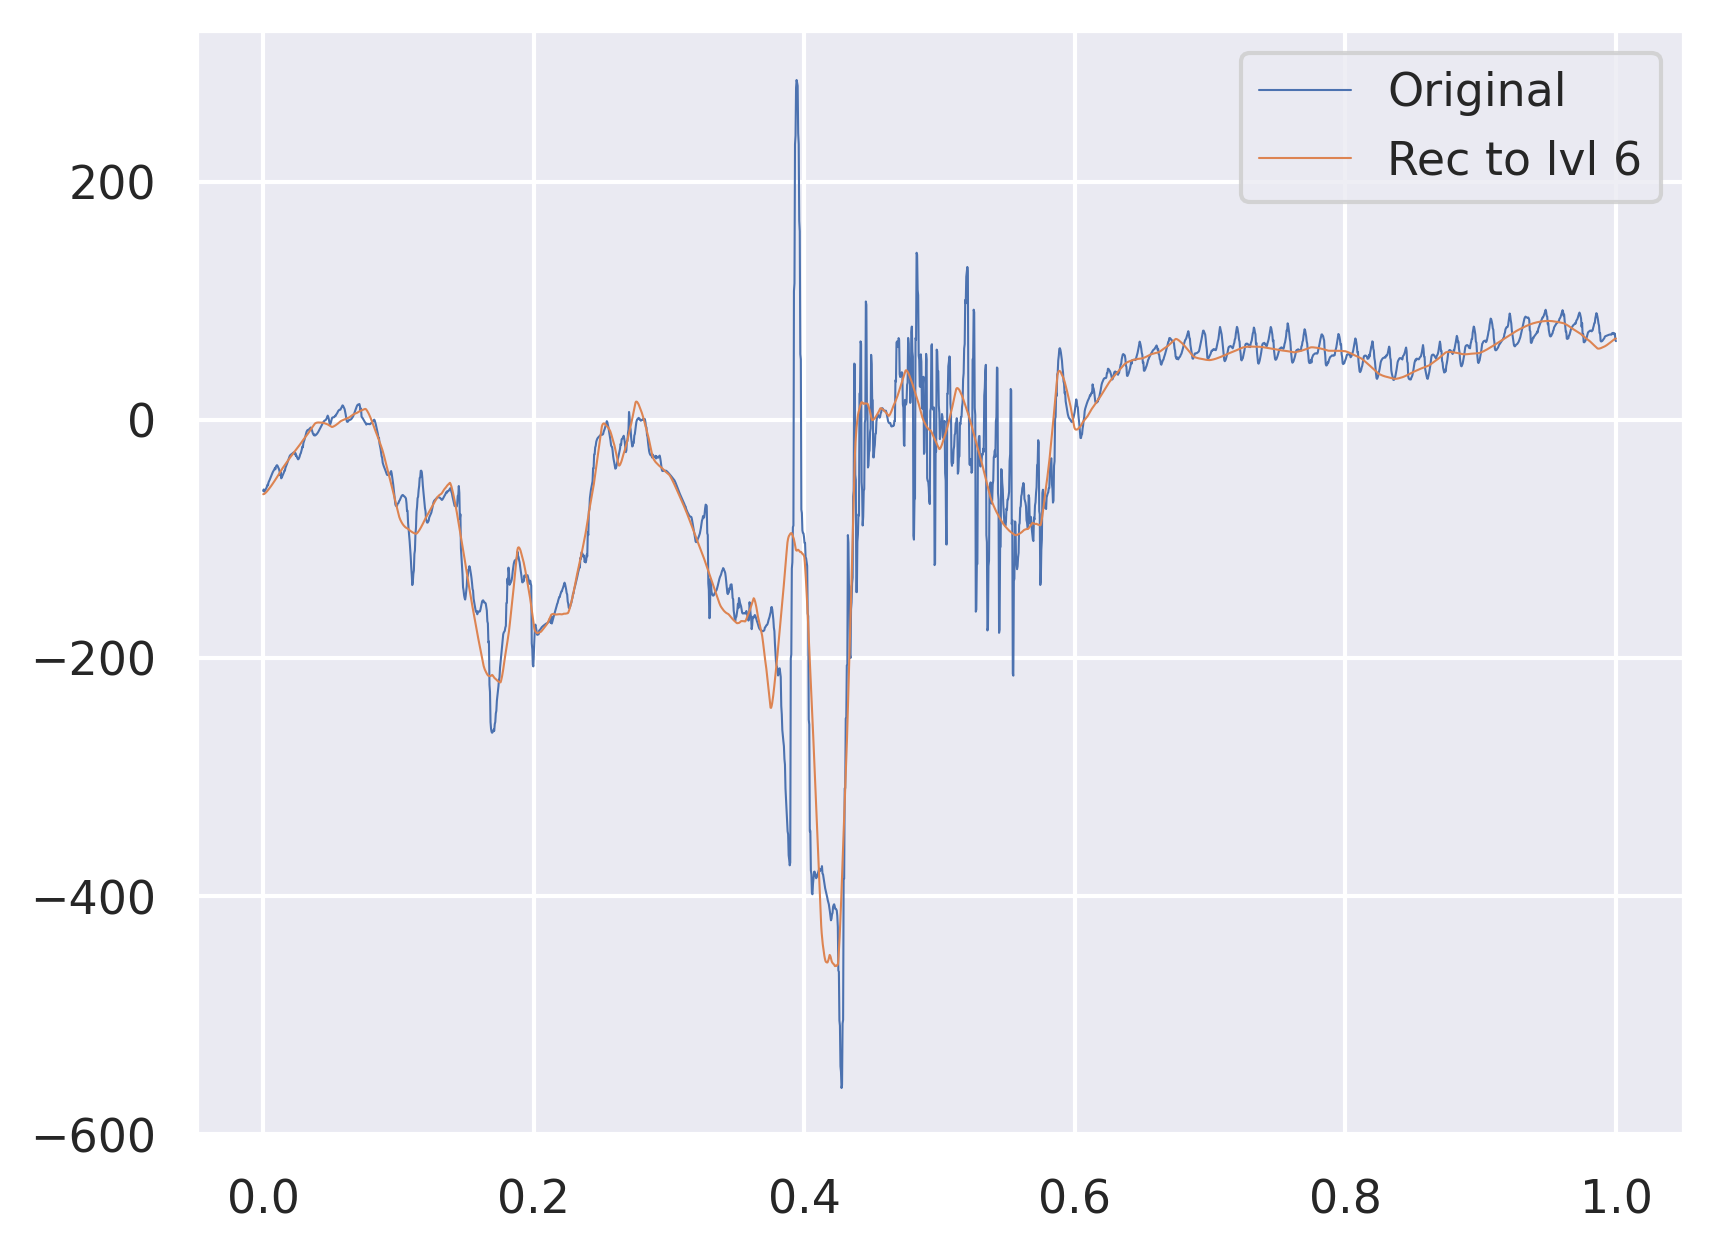

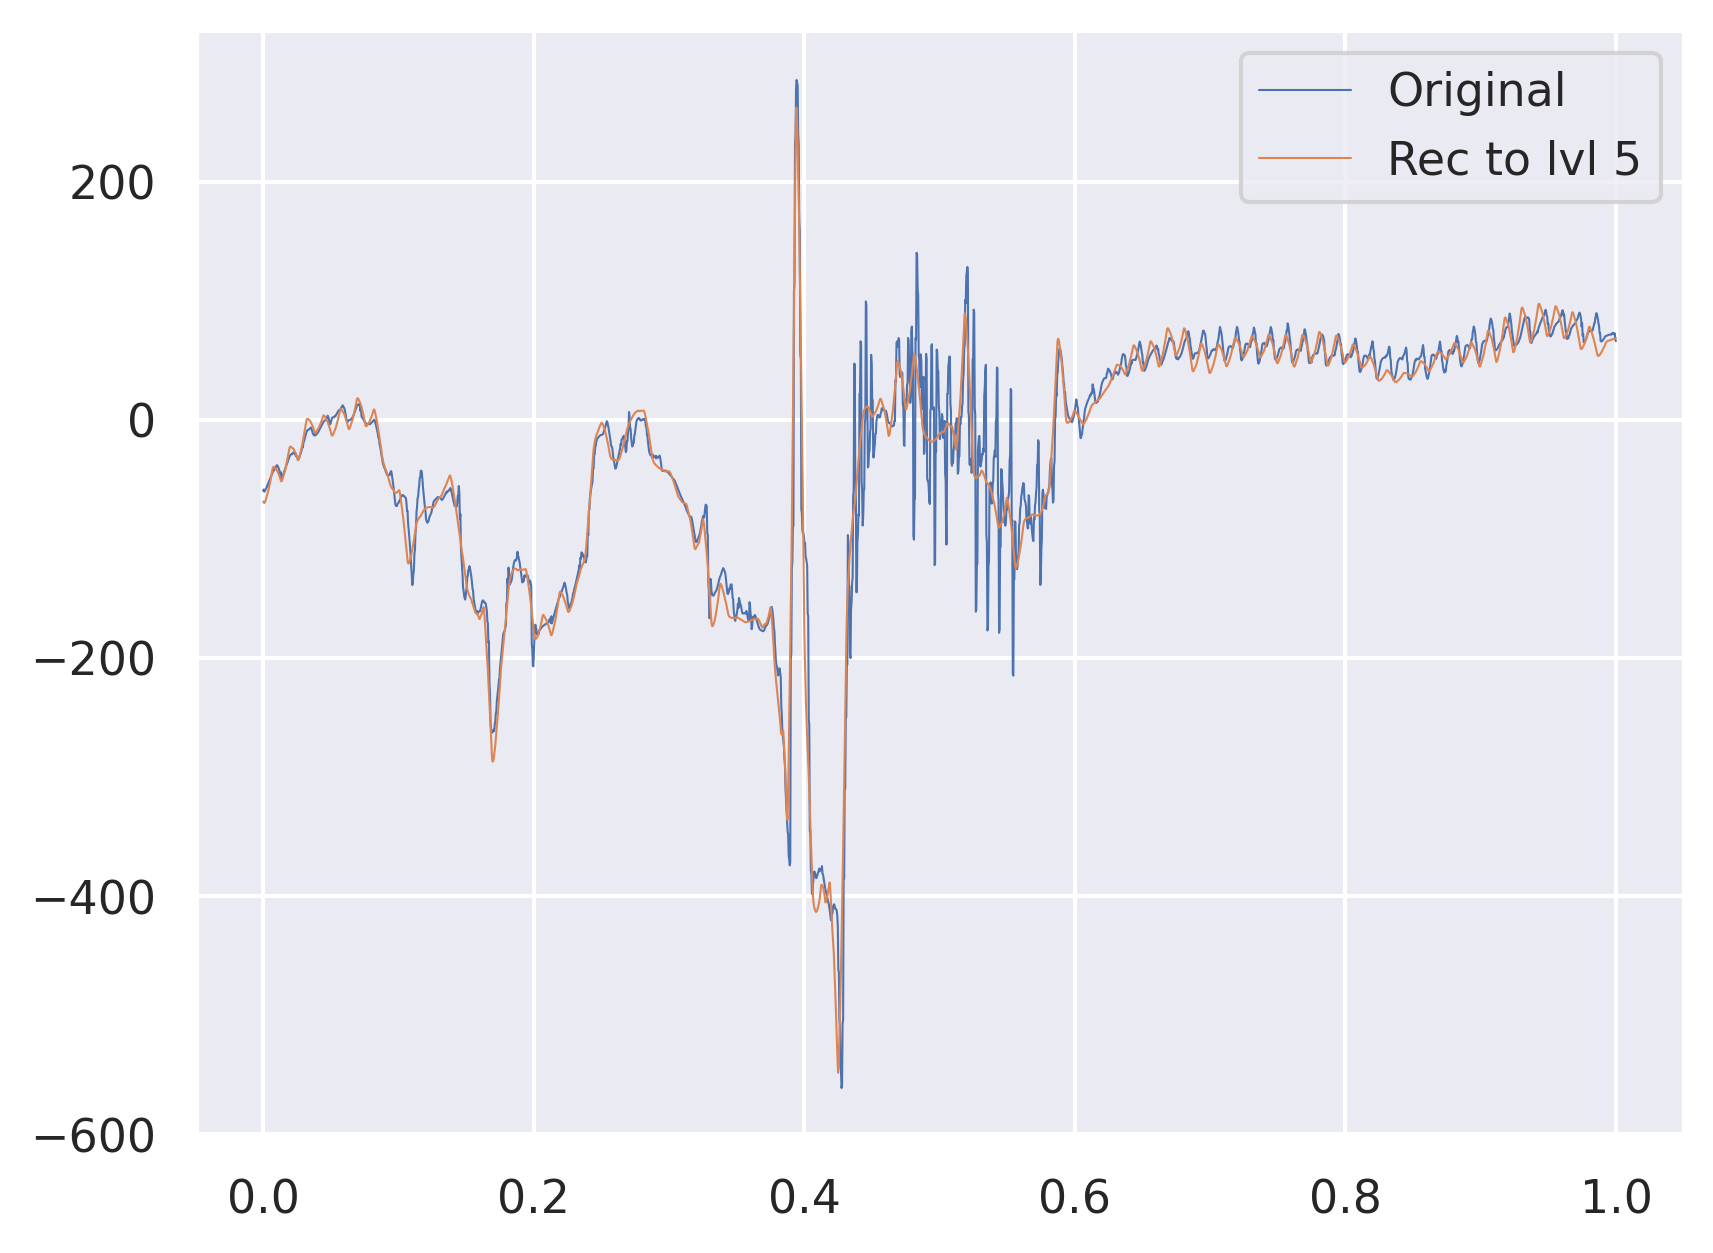

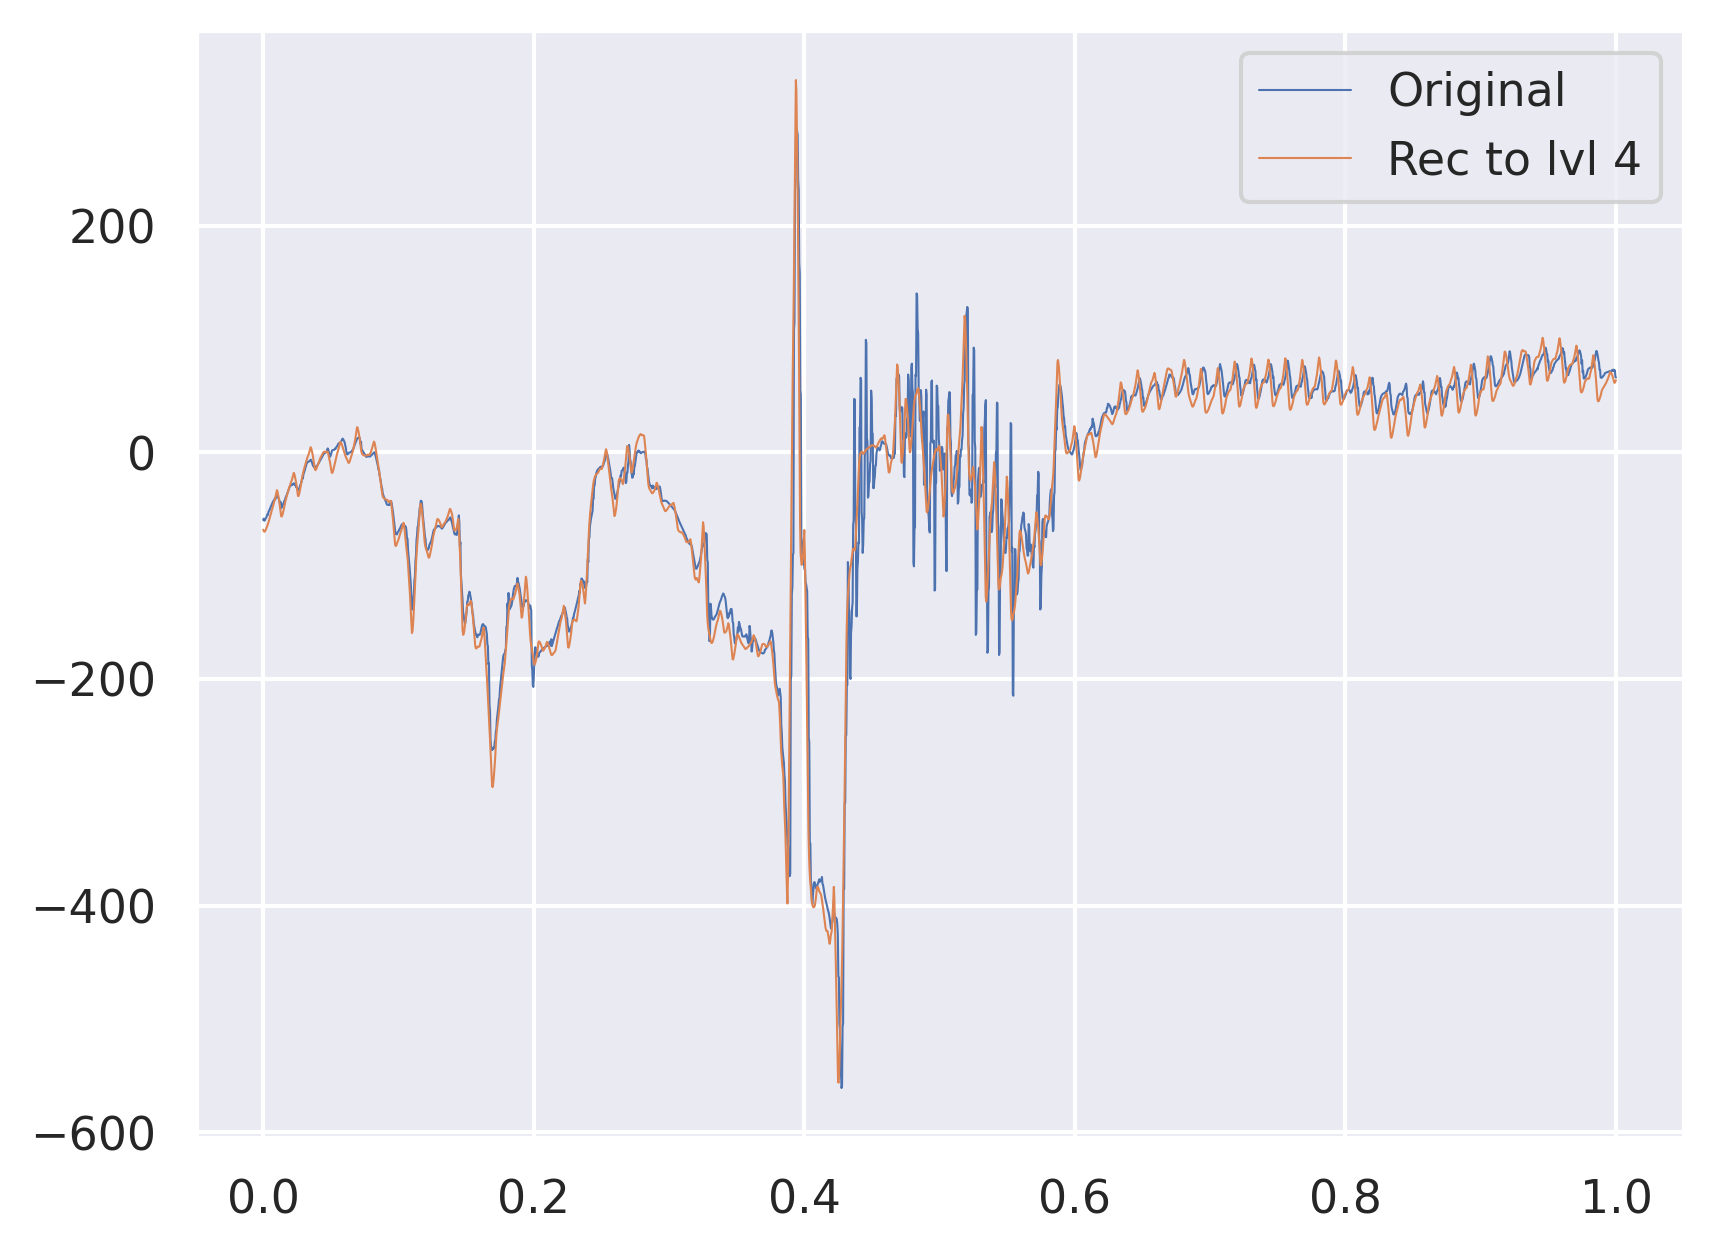

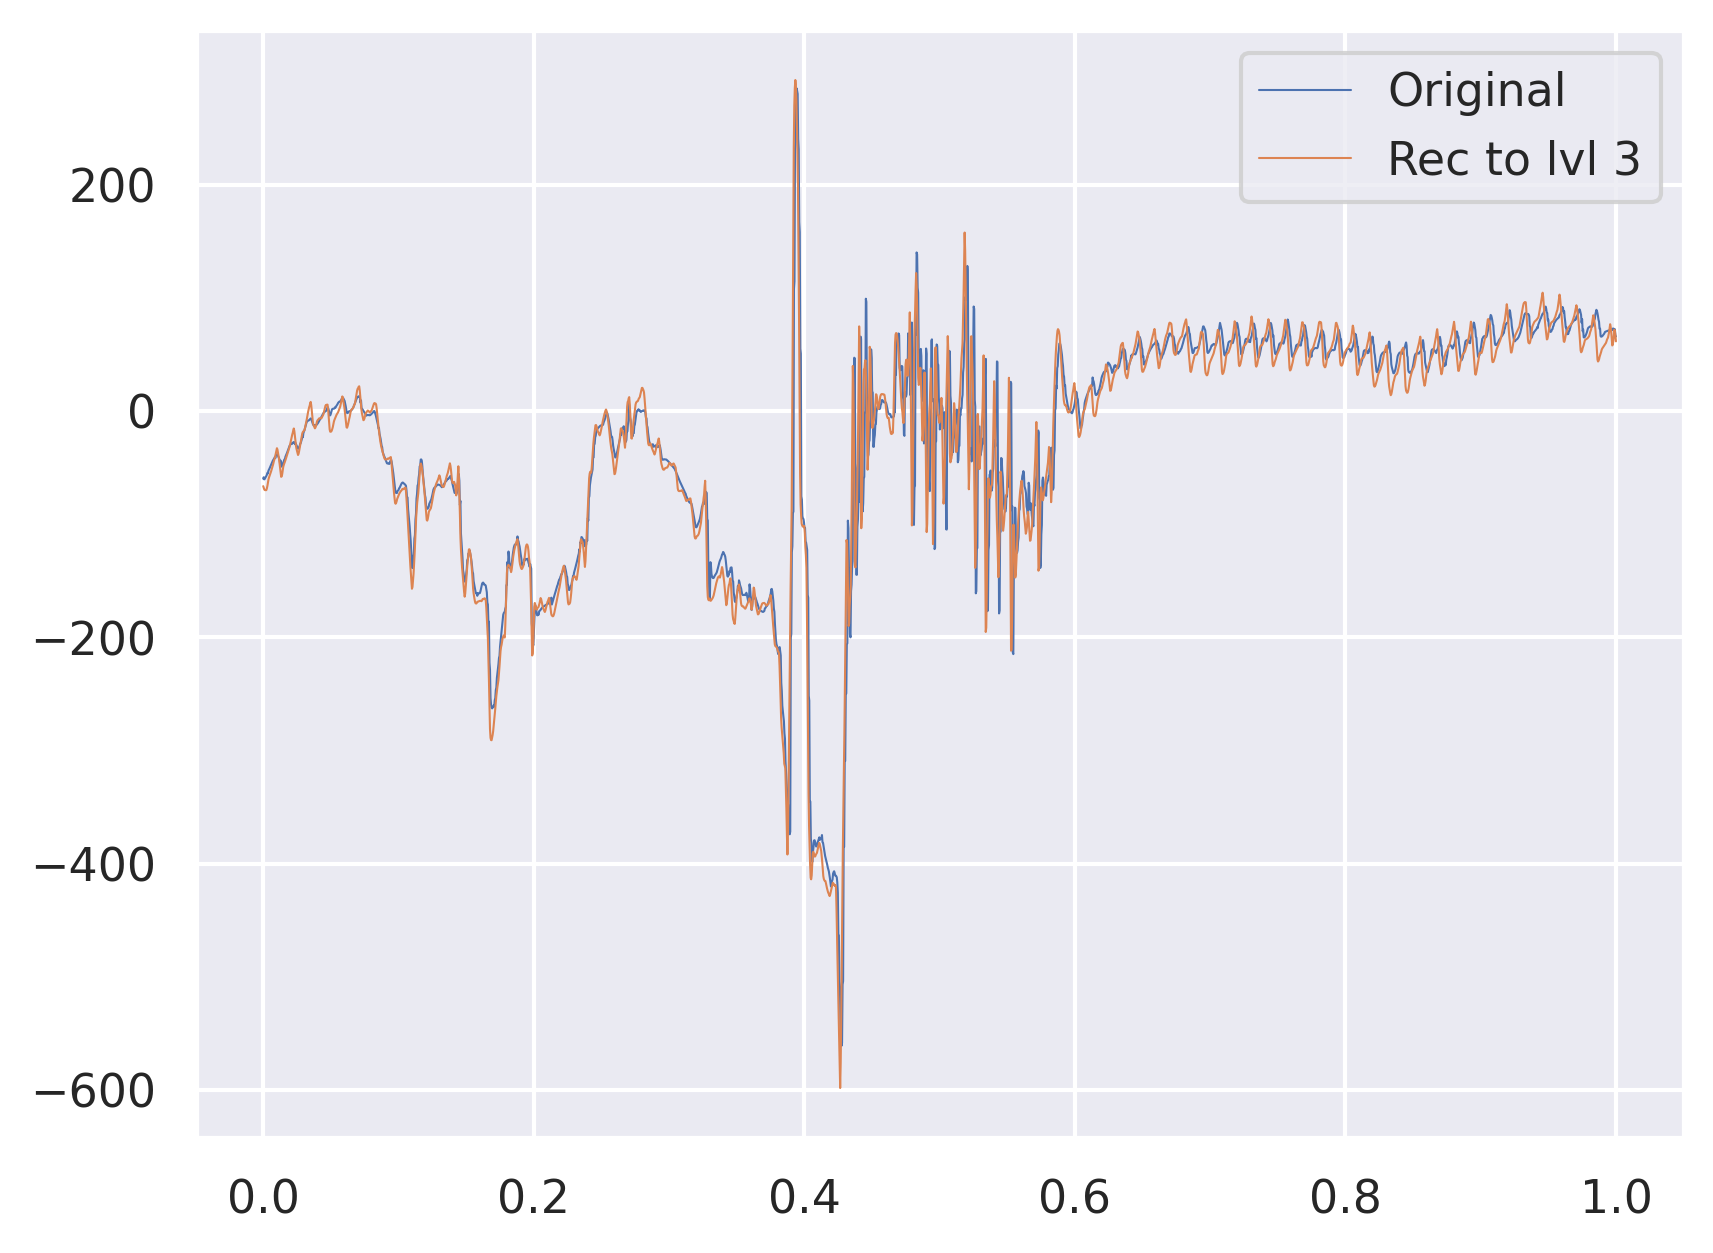

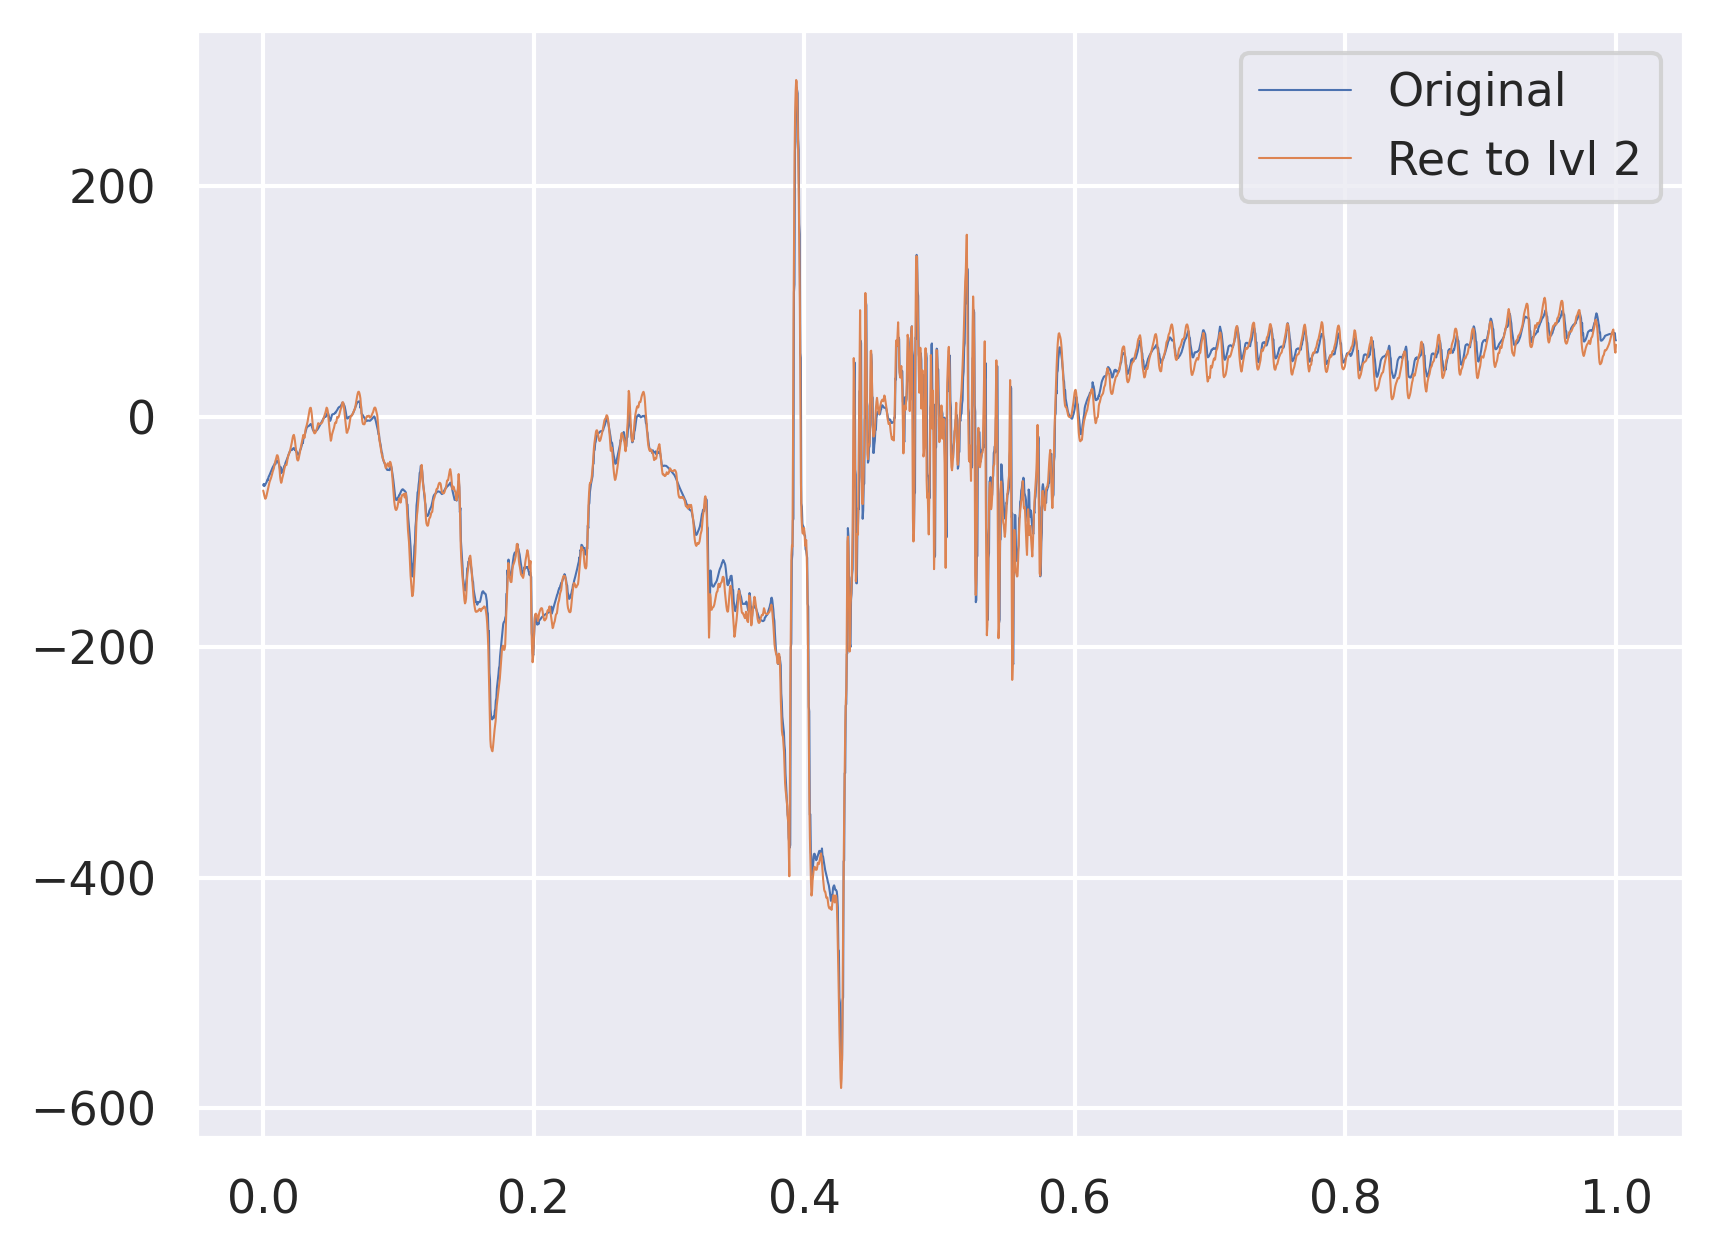

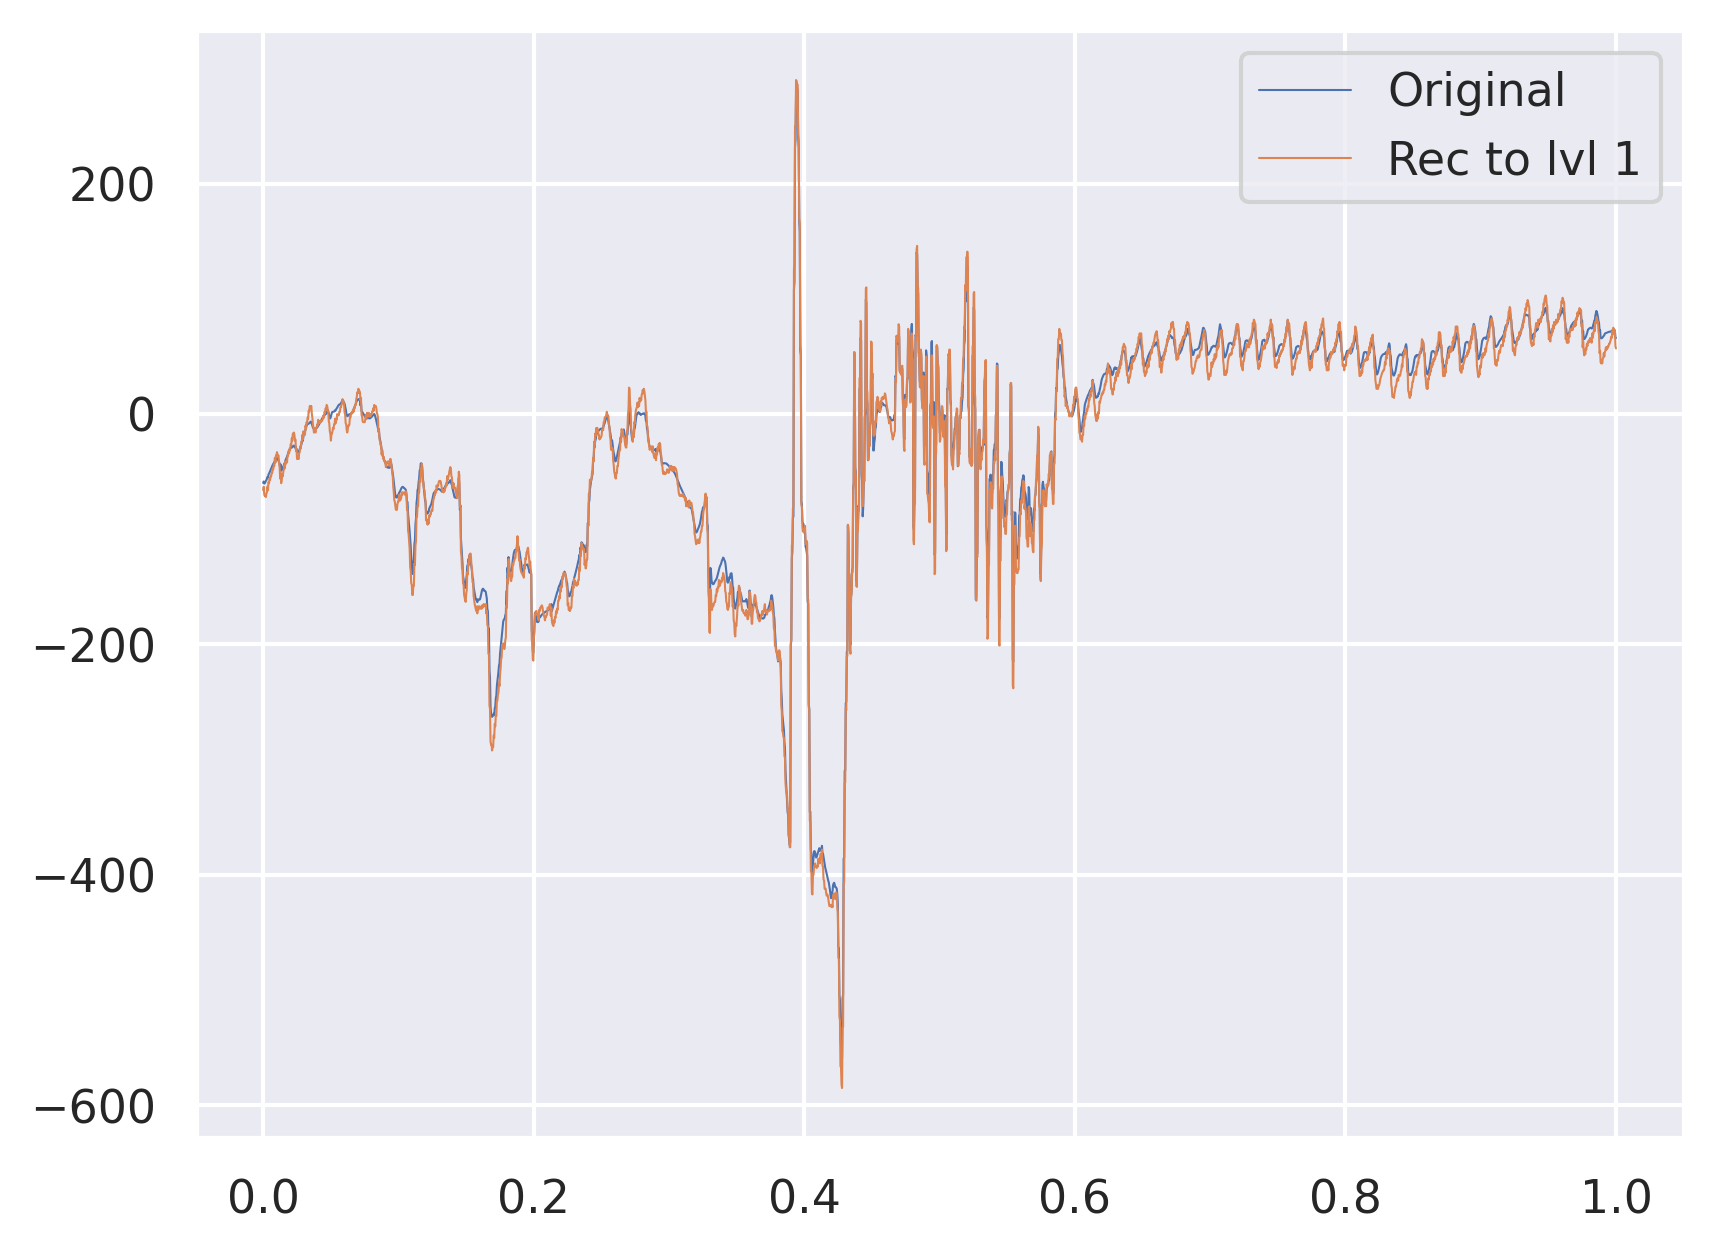

In [87]:
x = df['red_denoised']
xmax = df['red_denoised'].max()
nl = len(coeffs)-1
for i in range(nl):
    plt.figure()
    reconstruction_plot(x, lw=0.5) # original signal 
    # reconstruction_plot(pywt.waverec(coeffs, w), lw=0.5) # full reconstruction 
    reconstruction_plot(pywt.waverec(coeffs[:i+2] + [None] * (nl-i-1), w), lw=0.5) # partial reconstruction 
    # reconstruction_stem(coeffs[i+1], xmax, markerfmt ='none', linefmt='r-')
    #plt.legend(['Original', 'Full reconstruction', ('Rec to lvl %d')%(nl-i), ('Details for lvl %d')%(nl-i)])
    plt.legend(['Original', ('Rec to lvl %d')%(nl-i), ('Details for lvl %d')%(nl-i)])